In [ ]:
'''
5.3.2　微调模型
'''

#对于用于特征提取的冻结的模型基，微调是指将其顶部的几层“解冻”，并将这解冻的几层和新增加的部分（本例中是全连接分类器）联合训练

#步骤：
#(1) 在已经训练好的基网络（base network）上添加自定义网络。
#(2) 冻结基网络。
#(3) 训练所添加的部分。
#(4) 解冻基网络的一些层。
#(5) 联合训练解冻的这些层和添加的部分。

In [1]:
# 在做特征提取时已经完成了前三个步骤。我们继续进行第四步：先解冻 conv_base ，然后冻结其中的部分层。
# 我们将微调最后三个卷积层

# 将 VGG16 卷积基实例化
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',# weights 指定模型初始化的权重检查点
                  include_top=False,#  include_top 指定模型最后是否包含密集连接分类器。默认情况下，这个密集连接分
                                    # 类器对应于 ImageNet 的 1000 个类别。因为我们打算使用自己的密集连接分类器（只有
                                    # 两个类别： cat 和 dog ），所以不需要包含它。
                  input_shape=(150, 150, 3))#  input_shape 是输入到网络中的图像张量的形状。这个参数完全是可选的，如果不传
                                            # 入这个参数，那么网络能够处理任意形状的输入。
conv_base.summary()

Using TensorFlow backend.



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0    

In [ ]:
'''
5.4　卷积神经网络的可视化
'''
# 5.4.1可视化卷积神经网络的中间输出（中间激活）：
# 有助于理解卷积神经网络连续的层如何对输入进行变换，也有助于初步了解卷积神经网络每个过滤器的含义。

# 5.4.2可视化卷积神经网络的过滤器：
# 有助于精确理解卷积神经网络中每个过滤器容易接受的视觉模式或视觉概念。

# 5.4.3可视化图像中类激活的热力图：
# 有助于理解图像的哪个部分被识别为属于某个类别，从而可以定位图像中的物体。
'''
5.4.1　可视化中间激活
'''

In [2]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary() # 作为提醒

# 预处理单张图像
img_path = r'D:\dogs_vs_cats\cats_and_dogs_small\test\cats\cat.1700.jpg'
from keras.preprocessing import image
import numpy as np
# 将图像预处理为一个 4D 张量
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# 其形状为 (1, 150, 150, 3)
print(img_tensor.shape)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________

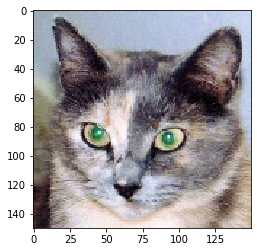

(1, 148, 148, 32)


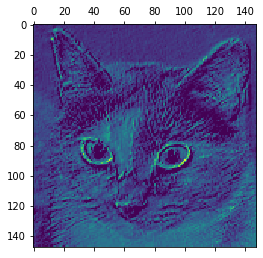

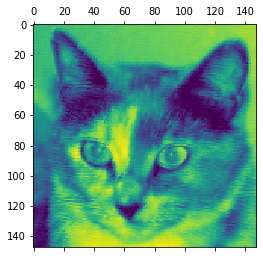

In [4]:
# 显示测试图像
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

# 用一个输入张量和一个输出张量列表将模型实例化
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# 以预测模式运行模型
activations = activation_model.predict(img_tensor)# 返回8个Numpy数组组成的列表，每个层激活对应一个 Numpy 数组

# 例如，对于输入的猫图像，第一个卷积层的激活如下所示。
first_layer_activation = activations[0]
# 它是大小为 148×148 的特征图，有 32 个通道。
print(first_layer_activation.shape)
# 我们来绘制原始模型第一层激活的第 4 个通道。
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
# 将第 7 个通道可视化
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


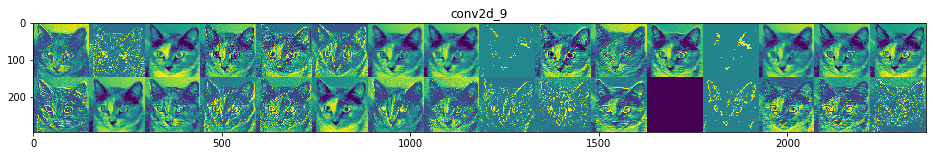

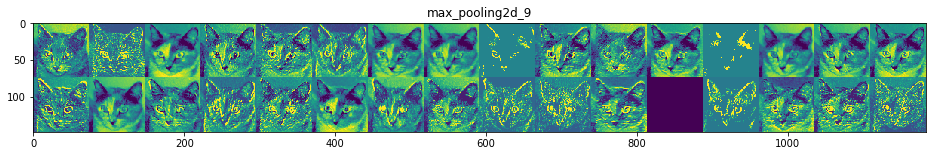

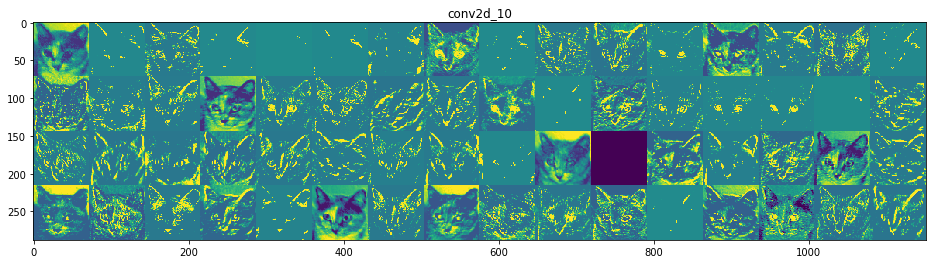

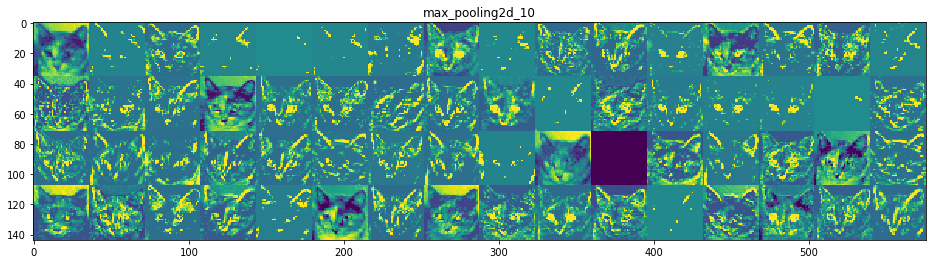

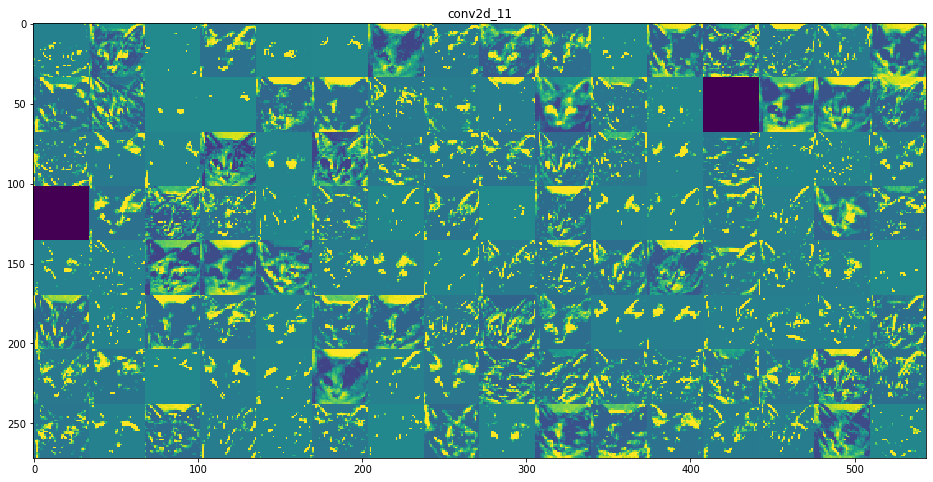

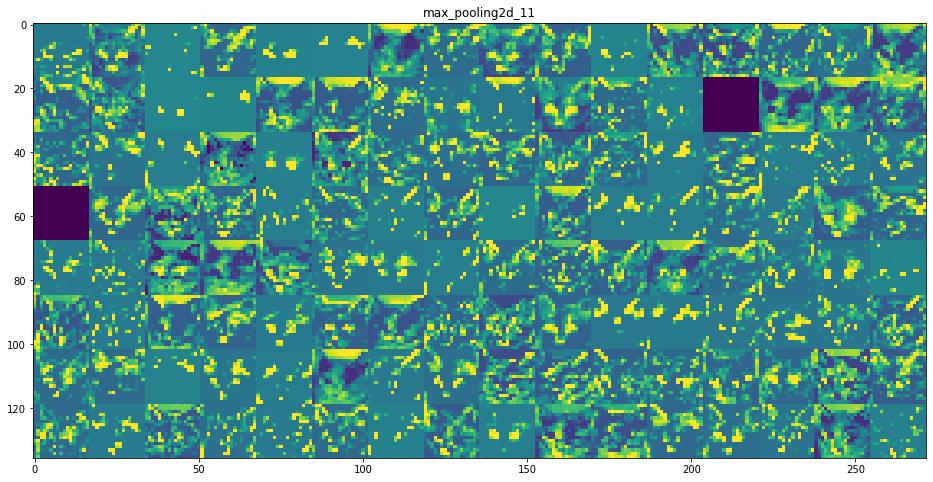

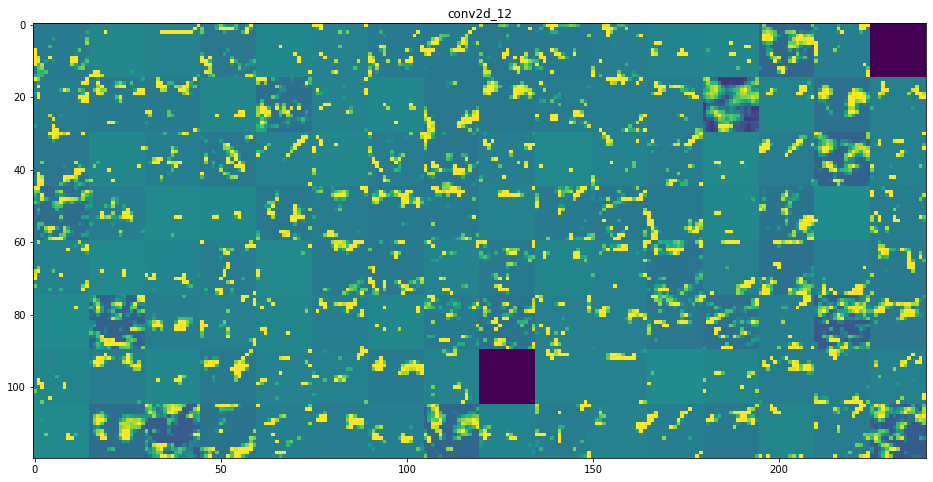

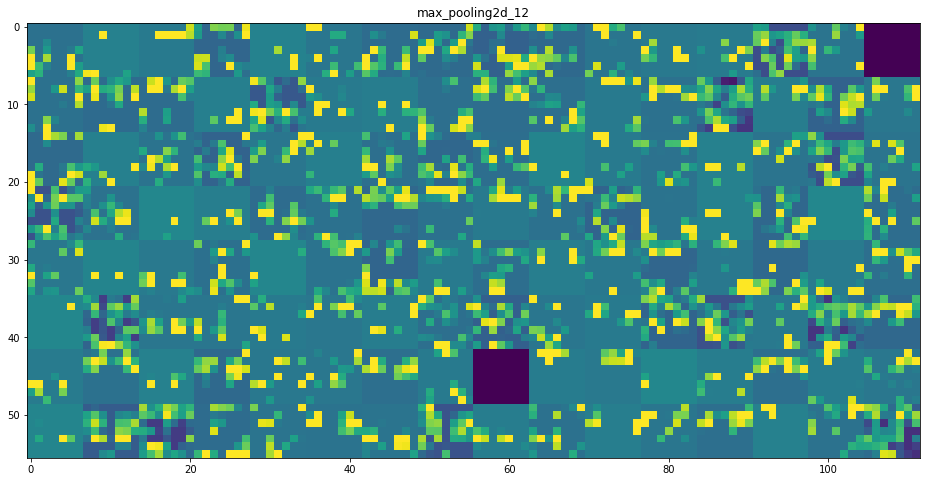

In [4]:
# 将每个中间激活的所有通道可视化
layer_names = []# 层的名称，这样可以将这些名称画到图中
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):# 显示特征图
    n_features = layer_activation.shape[-1]                       # 特征图中的特征个数
    
    size = layer_activation.shape[1]                              # 特征图的shape为 (1, size, size, n_features)
    
    n_cols = n_features // images_per_row                         # 在这个矩阵中将激活通道平铺
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):# 将每个过滤器平铺到一个大的水平网格中
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            
            # 对特征进行后处理，使其看起来更美观
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [7]:
# 第一层是各种边缘探测器的集合。在这一阶段，激活几乎保留了原始图像中的所有信息。
# 随着层数的加深，激活变得越来越抽象，并且越来越难以直观地理解。它们开始表示更
#高层次的概念，比如“猫耳朵”和“猫眼睛”。层数越深，其表示中关于图像视觉内容
#的信息就越少，而关于类别的信息就越多。
# 激活的稀疏度（sparsity）随着层数的加深而增大。在第一层里，所有过滤器都被输入图
#像激活，但在后面的层里，越来越多的过滤器是空白的。也就是说，输入图像中找不到
#这些过滤器所编码的模式

In [5]:
'''
5.4.2　可视化卷积神经网络的过滤器
'''
# 为过滤器的可视化定义损失张量
from keras.applications import VGG16
from keras import backend as K
model = VGG16(weights='imagenet',include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# 获取损失相对于输入的梯度
grads = K.gradients(loss, model.input)[0]# 调用 gradients 返回的是一个张量列表。因此，只保留第一个元素，它是一个张量

# 梯度标准化技巧
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)# 做除法前加上 1e–5 ，以防不小心除以 0

# 现在需要一种方法：给定输入图像，它能够计算损失张量和梯度张量的值。
# 定义一个 Keras 后端函数来实现此方法： iterate 是一个函数，它将一个 Numpy 张量（表示为长度为 1 的张量列表）转换为两个 Numpy 张量组成的列表，
# 这两个张量分别是损失值和梯度值。
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

# 通过随机梯度下降让损失最大化
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.# 从一张带有噪声的灰度图像开始
step = 1.# 每次梯度更新的步长
for i in range(40):# 运行 40 次梯度上升
    loss_value, grads_value = iterate([input_img_data])# 计算损失值和梯度值
    input_img_data += grads_value * step# 沿着让损失最大化的方向调节输入图像
    
# 得到的图像张量是形状为 (1, 150, 150, 3) 的浮点数张量，其取值可能不是 [0, 255] 区间内的整数。
# 　将张量转换为有效图像的实用函数
def deprocess_image(x):
    x -= x.mean()# 对张量做标准化，使其均值为0，
    x /= (x.std() + 1e-5)
    x *= 0.1# 标准差为 0.1
    
    x += 0.5# 将 x 裁切（ clip ）到 [0, 1] 区间
    x = np.clip(x, 0, 1)
    
    x *= 255# 将 x 转换为 RGB 数组
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
# 生成过滤器可视化的函数
# 构建一个损失函数，将该层第 n 个过滤器的激活最大化
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]# 计算这个损失相对于输入图像的梯度
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)# 标准化技巧：将梯度标准化
    iterate = K.function([model.input], [loss, grads])# 返回给定输入图像的损失和梯度
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.# 从带有噪声的灰度图像开始
    # 运行 40 次梯度上升
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

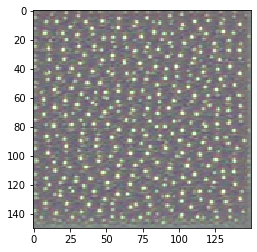

In [7]:
# 试用函数
plt.imshow(generate_pattern('block3_conv1', 0))

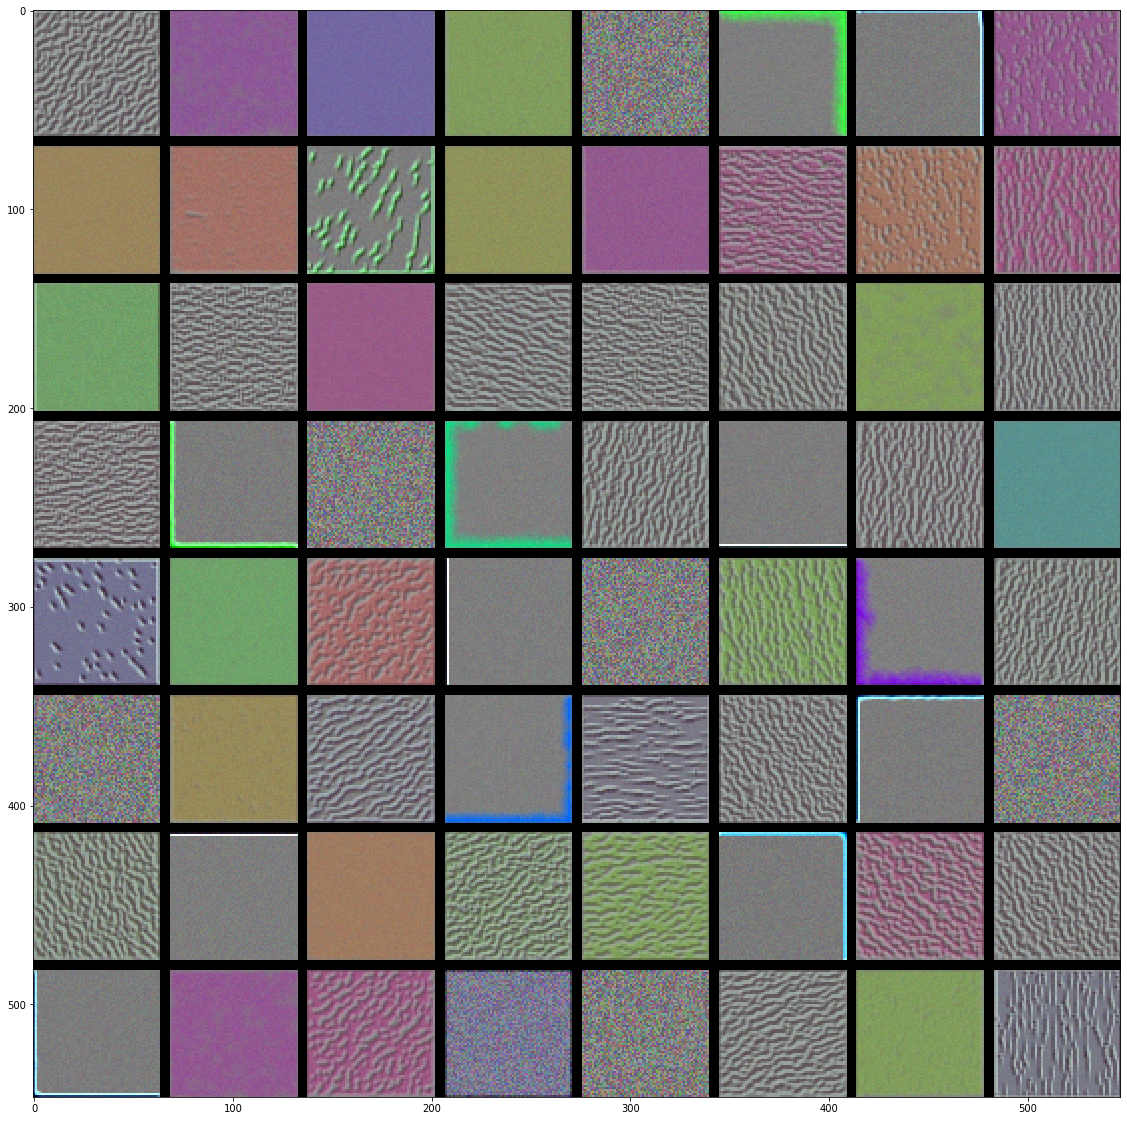

In [17]:
# 将每一层的每个过滤器都可视化。
# 为了简单起见，只查看每一层的前 64 个过滤器，并只查看每个卷积块的第一层（即 block1_conv1、block5_conv1）。
# 将输出放在一个 8×8 的网格中，每个网格是一个 64 像素×64 像素的过滤器模式，两个过滤器模式之间留有一些黑边

# 生成某一层中所有过滤器响应模式组成的网格
layer_name = 'block1_conv1'
size = 64
margin = 5
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))# 空图像（全黑色），用于保存结果
for i in range(8):# 遍历 results 网格的行
    for j in range(8):# 遍历 results 网格的列
        # 生成 layer_name 层第i +（j * 8）个过滤器的模式
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        # 将结果放到 results 网格第 (i, j) 个方块中
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,vertical_start: vertical_end, :] = filter_img / 256
# 显示 results 网格 
plt.figure(figsize=(20, 20))
plt.imshow(results)

In [1]:
'''
5.4.3　可视化类激活的热力图
'''
# 类激活图（CAM，class activation map）可视化
# 有助于了解一张图像的哪一部分让卷积神经网络做出了最终的分类决策
# 给定一张输入图像，对于一个卷积层的输出特征图，用类别相对于通道的梯度对这个特征图中的每个通道进行加权。
# 直观上来看，理解这个技巧的一种方法是，
# 你是用“每个通道对类别的重要程度”对“输入图像对不同通道的激活强度”的空间图进行加权，从而得到了“输入图像对类别的激活强度”的空间图。

# 加载带有预训练权重的 VGG16 网络
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')# 注意，网络中包括了密集连接分类器。

# 这些训练图像都根据 keras.applications.vgg16.preprocess_input 函数中内置的规则进行预处理。
# 因此，我们需要加载图像，将其大小调整为 224×224，然后将其转换为 float32 格式的 Numpy 张量，并应用这些预处理规则。

# 为 VGG16 模型预处理一张输入图像
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
img_path = '.\creative_commons_elephant.png'# 目标图像的本地路径
img = image.load_img(img_path, target_size=(224, 224))# 大 小 为 224×224 的 Python图像库（PIL，Python imaginglibrary）图像
x = image.img_to_array(img)# 形 状 为 (224, 224, 3) 的float32 格式的 Numpy 数组
print(x)
x = np.expand_dims(x, axis=0)# 添加一个维度，将数组转换为(1, 224, 224, 3) 形状的批量
x = preprocess_input(x)# 对批量进行预处理（按通道进行颜色标准化）

# 现在你可以在图像上运行预训练的 VGG16 网络，并将其预测向量解码为人类可读的格式。
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Using TensorFlow backend.



[[[184. 205. 226.]
  [184. 207. 226.]
  [183. 206. 225.]
  ...
  [178. 191. 213.]
  [178. 191. 213.]
  [177. 190. 212.]]

 [[186. 207. 227.]
  [185. 208. 227.]
  [184. 207. 226.]
  ...
  [177. 190. 213.]
  [177. 190. 213.]
  [176. 189. 211.]]

 [[185. 208. 225.]
  [187. 207. 228.]
  [185. 206. 224.]
  ...
  [176. 192. 215.]
  [178. 192. 213.]
  [178. 191. 213.]]

 ...

 [[106. 126.  77.]
  [107. 130.  75.]
  [ 87. 109.  56.]
  ...
  [ 96. 105.  74.]
  [ 88. 100.  64.]
  [ 79.  89.  55.]]

 [[102. 123.  69.]
  [ 98. 120.  65.]
  [ 84. 106.  52.]
  ...
  [106. 119.  85.]
  [ 79.  90.  54.]
  [ 95. 106.  70.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]

40960/35363 [==================================] - 1s 18us/step
Predicted: [('n02504458', 'African_elephant', 0.80480677), ('n01871265', 'tusker', 0.17822064), ('n02504013', 'Indian_elephant', 0.016250893)]


In [3]:
from keras import backend as K
# 应用 Grad-CAM 算法
african_elephant_output = model.output[:, 386]
# 预测向量中的“非洲象”元素

last_conv_layer = model.get_layer('block5_conv3')
# block5_conv3 层的输出特征图，它是 VGG16 的最后一个卷积层

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
# “非洲象”类别相对于 block5_conv3输出特征图的梯度

pooled_grads = K.mean(grads, axis=(0, 1, 2))
# 形状为 (512,) 的向量，每个元素是特定特征图通道的梯度平均大小

iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])
# 访问刚刚定义的量：对于给定的样本图像，pooled_grads 和 block5_conv3 层的输出特征图

pooled_grads_value, conv_layer_output_value = iterate([x])
# 对于两个大象的样本图像，这两个量都是 Numpy 数组

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    # 将特征图数组的每个通道乘以“这个通道对‘大象’类别的重要程度”
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
# 得到的特征图的逐通道平均值即为类激活的热力图

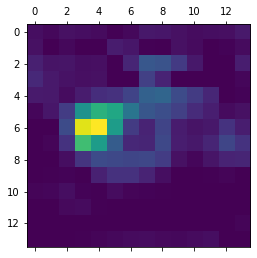

In [6]:
import matplotlib.pyplot as plt
# 热力图后处理
# 为了便于可视化，我们还需要将热力图标准化到 0~1 范围内
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [ ]:
# 可以用 OpenCV 来生成一张图像，将原始图像叠加在刚刚得到的热力图上
import cv2
img = cv2.imread(img_path)
# 用 cv2 加载原始图像

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# 将热力图的大小调整为与原始图像相同

heatmap = np.uint8(255 * heatmap)
# 将热力图转换为 RGB 格式

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 将热力图应用于原始图像

superimposed_img = heatmap * 0.4 + img
# 这里的 0.4 是热力图强度因子

cv2.imwrite('.\elephant_cam.jpg', superimposed_img)
# 将图像保存到硬盘